# Image Classifcation using Real-world Images (Cats vs Dogs)

### Import the Libraries

In [549]:
import tensorflow as tf
import os
import random
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from ipywidgets import widgets
from io import BytesIO
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

### Preview the Dataset
**Dataset:** https://www.kaggle.com/c/dogs-vs-cats/data

In [552]:
CAT_DIR = 'cats vs dogs/Cat'
DOG_DIR = 'cats vs dogs/Dog'

print(f"Total Cat images: {len(os.listdir(CAT_DIR))}")
print(f"Total Dog images: {len(os.listdir(DOG_DIR))}")

Total Cat images: 1001
Total Dog images: 1001


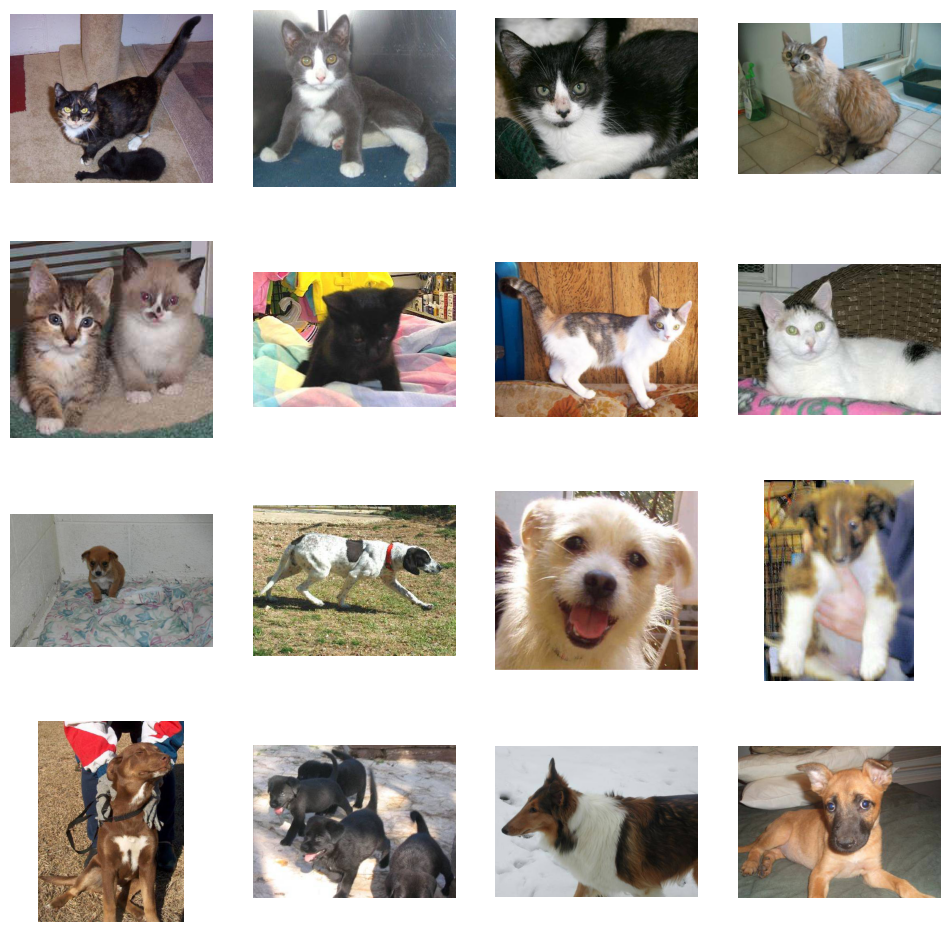

In [554]:
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

next_Cat_pix = [os.path.join(CAT_DIR, fname)
                for fname in random.sample(os.listdir(CAT_DIR), k=8)]
next_Dog_pix = [os.path.join(DOG_DIR, fname)
                for fname in random.sample(os.listdir(DOG_DIR), k=8)]

for i, img_path in enumerate(next_Cat_pix + next_Dog_pix):
    
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

### Preprocessing Images to Train a Neural Network

The tf.data API is a powerful tool in TensorFlow for building complex input pipelines. One common use case is loading, processing, and batching image data for machine learning models. The image_dataset_from_directory utility is part of this API and is specifically designed for creating a dataset from images stored in a directory structure.\
The image_dataset_from_directory function takes a directory structure where subdirectories represent class labels, and each image file inside those subdirectories represents a sample from that class. The subdirectory names automatically become the class labels when the dataset is created. The images are loaded and preprocessed into a TensorFlow Dataset object, which can then be used to train a model.

                                    TRAIN_DIR/ 
                                        ├── class_a/
                                        │   ├── image1.jpg
                                        │   ├── image2.jpg
                                        │   └── ...
                                        ├── class_b/
                                        │   ├── image1.jpg
                                        │   ├── image2.jpg
                                        │   └── ...
                                        └── ...

In [559]:
TRAIN_DIR = 'cats vs dogs'
sub_directories = os.listdir(TRAIN_DIR)
print("List of sub-directories:", sub_directories)

CAT_DIR = os.path.join(TRAIN_DIR, 'Cat')
print("First 5 images in CAT_DIR:", os.listdir(CAT_DIR)[0:5])
DOG_DIR = os.path.join(TRAIN_DIR, 'Dog')
print("First 5 images in DOG_DIR:", os.listdir(DOG_DIR)[0:5])


List of sub-directories: ['Cat', 'Dog']
First 5 images in CAT_DIR: ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']
First 5 images in DOG_DIR: ['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.1000.jpg']


In [561]:
training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory( 
    directory=TRAIN_DIR,
    image_size=(150, 150),
    batch_size=128,
    label_mode='binary',
    validation_split=0.15,
    subset='both',
    seed=42 
)
print("Classes Labels:", train_dataset.class_names)

Found 2002 files belonging to 2 classes.
Using 1702 files for training.
Using 300 files for validation.
Classes Labels: ['Cat', 'Dog']


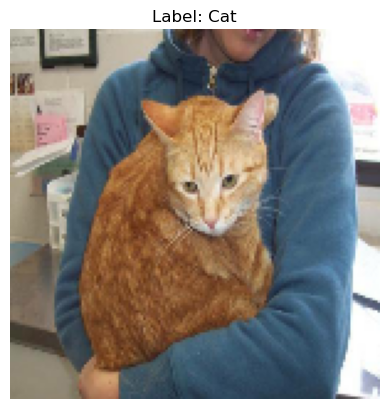

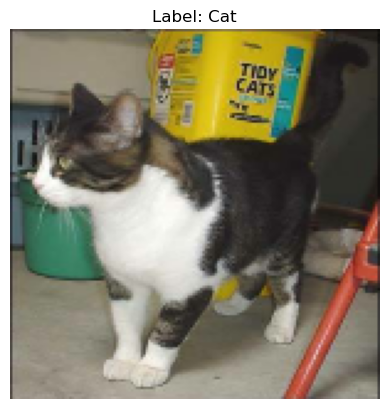

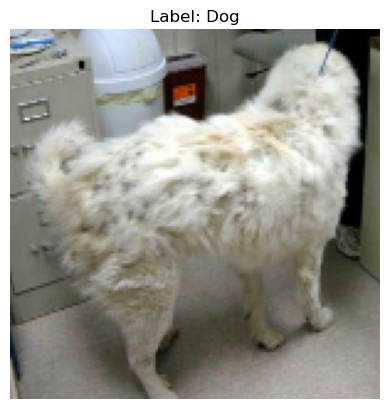

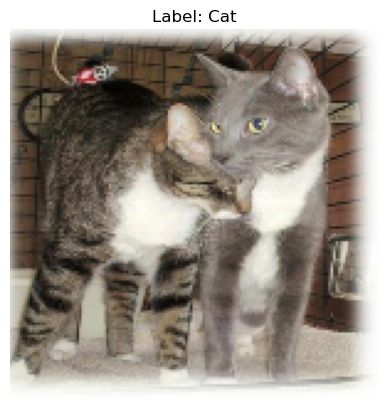

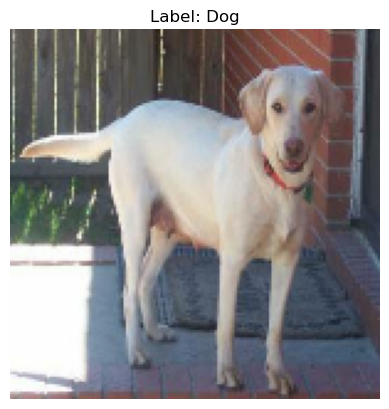

In [563]:
class_names = training_dataset.class_names
# Get a batch of images and labels
for images, labels in training_dataset.take(1):
    # Plot a few sample images
    for i in range(5):  # Show first 5 images
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {class_names[int(labels[i].numpy())]}")
        plt.axis("off")
        plt.show()

**Normalizing the Images**

In [565]:
sample_batch = list(training_dataset.take(1))[0]
image_batch = sample_batch[0]
print(f'max value: {np.max(image_batch[0].numpy())}')
print(f'min value: {np.min(image_batch[0].numpy())}')

max value: 255.0
min value: 2.757594585418701


In [567]:
rescale_layer = tf.keras.layers.Rescaling(scale=1./255)
train_dataset_scaled = training_dataset.map(lambda image, label: (rescale_layer(image), label))
validation_dataset_scaled = validation_dataset.map(lambda image, label: (rescale_layer(image), label))

In [570]:
sample_batch =  list(train_dataset_scaled.take(1))[0]

# Get the image
image_scaled = sample_batch[0][1].numpy()

# Check the range of values for this image
print(f'max value: {np.max(image_scaled)}')
print(f'min value: {np.min(image_scaled)}')

max value: 0.9947651028633118
min value: 0.01673204079270363


**Configuring the Dataset**
* [cache()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) stores elements in memory as you use them so it will be faster to retrieve if you need them again
* [shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), as the name suggests, shuffles the dataset randomly. A `buffer_size` of 1000 means it will first select a sample from the first 1,000 elements, then keep filling this buffer until all elements have been selected.
* [prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) gets elements while the model is training so it's faster to feed in new data when the current training step is finished. A `buffer_size` set to `tf.data.AUTOTUNE` dynamically sets the number of elements to prefetch during runtime.

`cache()` and `prefetch()` are particularly useful in speeding up the training. Removing these will make the training time per epoch about 3 to 4 times longer.

In [573]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                      )
val_dataset_final = (validation_dataset_scaled
                       .cache()
                       .prefetch(PREFETCH_BUFFER_SIZE)
                      )

### Create and Compile Model

In [576]:
def create_model():

    model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0 to 1 where 0 is for 'horses' and 1 for 'humans'
    tf.keras.layers.Dense(1, activation='sigmoid')
])
    return model

In [578]:
model = create_model()
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_436 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_76 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_437 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_77 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_438 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_78 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_439 (Conv2D)                  │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_79 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_440 (Conv2D)                  │ (None, 5, 5, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_80 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 229,537 (896.63 KB)

 Trainable params: 229,537 (896.63 KB)

 Non-trainable params: 0 (0.00 B)

In [580]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Training

In [583]:
history = model.fit(
      train_dataset_final,
      epochs= 80,
      validation_data=val_dataset_final,
      verbose=2)

Epoch 1/80
14/14 - 20s - 1s/step - accuracy: 0.4882 - loss: 0.6942 - val_accuracy: 0.4567 - val_loss: 0.6966
Epoch 2/80
14/14 - 12s - 838ms/step - accuracy: 0.5082 - loss: 0.6930 - val_accuracy: 0.5367 - val_loss: 0.6896
Epoch 3/80
14/14 - 11s - 795ms/step - accuracy: 0.5482 - loss: 0.6906 - val_accuracy: 0.5400 - val_loss: 0.6837
Epoch 4/80
14/14 - 11s - 788ms/step - accuracy: 0.5182 - loss: 0.6926 - val_accuracy: 0.5633 - val_loss: 0.6864
Epoch 5/80
14/14 - 11s - 793ms/step - accuracy: 0.5517 - loss: 0.6910 - val_accuracy: 0.5733 - val_loss: 0.6824
Epoch 6/80
14/14 - 11s - 794ms/step - accuracy: 0.5776 - loss: 0.6849 - val_accuracy: 0.5567 - val_loss: 0.6827
Epoch 7/80
14/14 - 11s - 797ms/step - accuracy: 0.5952 - loss: 0.6717 - val_accuracy: 0.4733 - val_loss: 0.7087
Epoch 8/80
14/14 - 11s - 782ms/step - accuracy: 0.5699 - loss: 0.6733 - val_accuracy: 0.6333 - val_loss: 0.6568
Epoch 9/80
14/14 - 11s - 769ms/step - accuracy: 0.6210 - loss: 0.6566 - val_accuracy: 0.5900 - val_loss: 0.

In [587]:
def plot_loss_acc(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'r', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'r', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

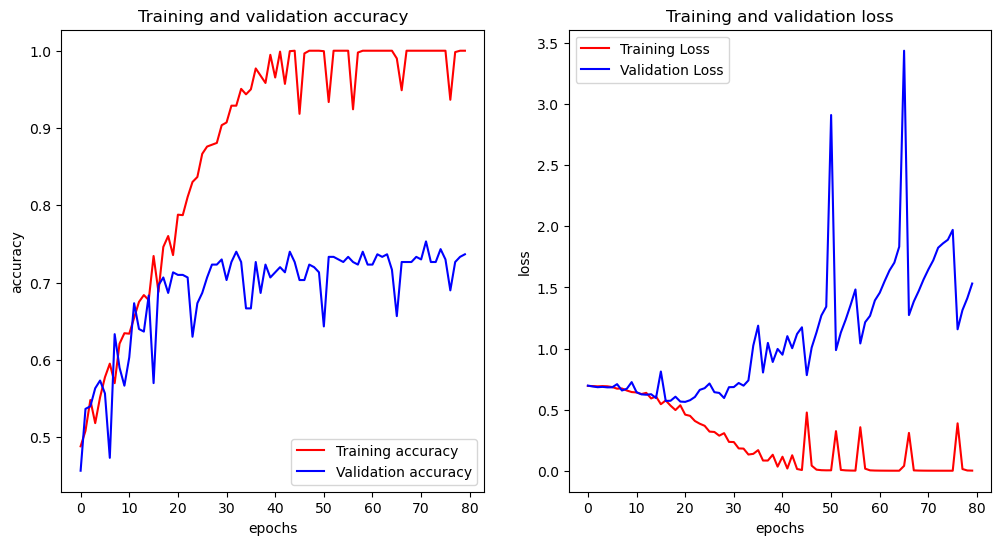

In [589]:
plot_loss_acc(history)

The training accuracy is reaching 100%, and the validation accuracy is in the 65%-75% range. The model is clearly overfitting that is it can do very well with images it has seen before, but not so well with images it hasn't.

### DATA AUGMENTATION
One simple method to avoid overfitting is to augment the images. If most pictures of a cat are very similar -- the ears are at the top, the eyes are below the ears etc. Things like the distance between the eyes and ears will always be quite similar too. Tweaking with the images a bit -- rotate the image, squash it, etc, that's what image augementation is all about. 

Building a data augmentation model with [preprocessing layers for image augmentation](https://www.tensorflow.org/guide/keras/preprocessing_layers#image_data_augmentation) will transform the data during training to introduce variations of the same image. 

* [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) is for randomly flipping the images horizontally, vertically, or both.
* [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation) rotates the image by an angle within a given range.
* [RandomTranslation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation) shifts pictures vertically and horizontally.
* [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) zooms into or out of the images.


In [614]:
# Define fill mode.
FILL_MODE = 'nearest'

# Create the augmentation model.
data_augmentation = tf.keras.Sequential([
    # Specify the input shape.
    tf.keras.Input(shape=(150,150,3)),
    # Add the augmentation layers
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.05, fill_mode=FILL_MODE)
    ])

In [616]:
model_without_aug = create_model()

# Prepend the data augmentation layers to the base model
model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model_without_aug
])

# Compile the model
model_with_aug.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

In [618]:
EPOCHS=80

# Train the new model
history_with_aug = model_with_aug.fit(
      train_dataset_final,
      epochs=EPOCHS,
      validation_data=val_dataset_final,
      verbose=2)

Epoch 1/80
14/14 - 17s - 1s/step - accuracy: 0.4947 - loss: 0.6927 - val_accuracy: 0.5533 - val_loss: 0.6918
Epoch 2/80
14/14 - 13s - 895ms/step - accuracy: 0.5529 - loss: 0.6918 - val_accuracy: 0.6133 - val_loss: 0.6895
Epoch 3/80
14/14 - 12s - 879ms/step - accuracy: 0.5629 - loss: 0.6910 - val_accuracy: 0.6167 - val_loss: 0.6887
Epoch 4/80
14/14 - 13s - 913ms/step - accuracy: 0.5599 - loss: 0.6894 - val_accuracy: 0.5867 - val_loss: 0.6852
Epoch 5/80
14/14 - 12s - 889ms/step - accuracy: 0.5582 - loss: 0.6888 - val_accuracy: 0.6700 - val_loss: 0.6847
Epoch 6/80
14/14 - 12s - 861ms/step - accuracy: 0.5828 - loss: 0.6872 - val_accuracy: 0.6367 - val_loss: 0.6813
Epoch 7/80
14/14 - 12s - 873ms/step - accuracy: 0.5893 - loss: 0.6844 - val_accuracy: 0.6133 - val_loss: 0.6775
Epoch 8/80
14/14 - 12s - 877ms/step - accuracy: 0.5670 - loss: 0.6818 - val_accuracy: 0.6233 - val_loss: 0.6736
Epoch 9/80
14/14 - 12s - 864ms/step - accuracy: 0.5881 - loss: 0.6786 - val_accuracy: 0.6867 - val_loss: 0.

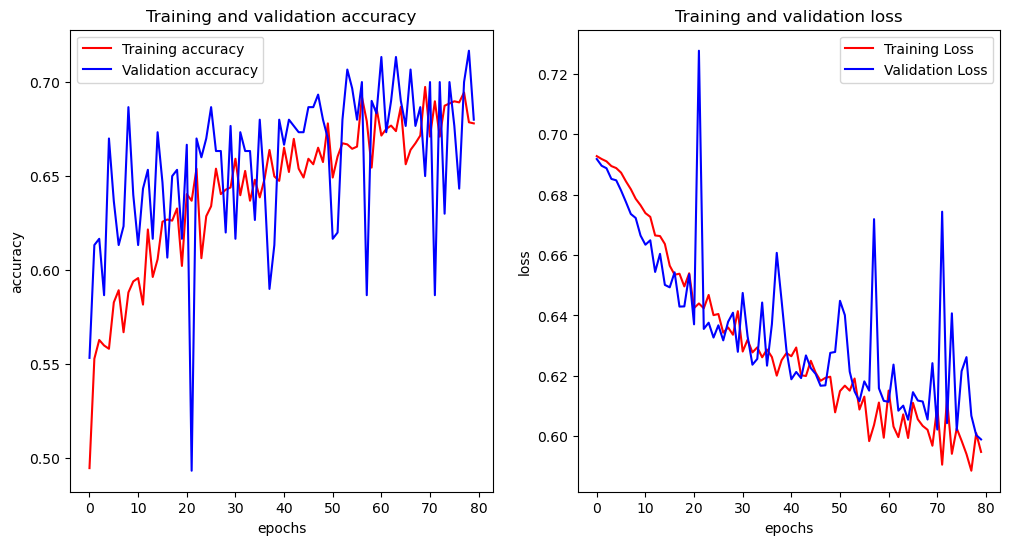

In [619]:
plot_loss_acc(history)

The training accuracy has gone down. This is expected because (as a result of data augmentation) there are more variety in the images so the model will need more runs to learn from them. The validation accuracy is no longer stalling and is more in line with the training results. This means that the model is now performing better on unseen data.

### TRANSFER LEARNING (InceptionV3)

In [643]:
# fetch the pretrained weights of the InceptionV3 model and remove the fully connected layer
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
    input_shape = (150, 150, 3),
    include_top = False,
    weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)



# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

In [644]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)   │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_639 (Conv2D)           │ (None, 74, 74, 32)        │             864 │ input_layer_39[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_564       │ (None, 74, 74, 32)        │              96 │ conv2d_639[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_564 (Activation)   │ (None, 74, 74, 32)        │               0 │ batch_normalization_564[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_640 (Conv2D)           │ (None, 72, 72, 32)        │           9,216 │ activation_564[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_565       │ (None, 72, 72, 32)        │              96 │ conv2d_640[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_565 (Activation)   │ (None, 72, 72, 32)        │               0 │ batch_normalization_565[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_641 (Conv2D)           │ (None, 72, 72, 64)        │          18,432 │ activation_565[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_566       │ (None, 72, 72, 64)        │             192 │ conv2d_641[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_566 (Activation)   │ (None, 72, 72, 64)        │               0 │ batch_normalization_566[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_99              │ (None, 35, 35, 64)        │               0 │ activation_566[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_642 (Conv2D)           │ (None, 35, 35, 80)        │           5,120 │ max_pooling2d_99[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_567       │ (None, 35, 35, 80)        │             240 │ conv2d_642[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_567 (Activation)   │ (None, 35, 35, 80)        │               0 │ batch_normalization_567[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_643 (Conv2D)           │ (None, 33, 33, 192)       │         138,24

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [645]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [646]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (1, activation='sigmoid')(x)

# Append the dense network to the base model
TL_model = tf.keras.Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
TL_model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)   │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_639 (Conv2D)           │ (None, 74, 74, 32)        │             864 │ input_layer_39[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_564       │ (None, 74, 74, 32)        │              96 │ conv2d_639[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_564 (Activation)   │ (None, 74, 74, 32)        │               0 │ batch_normalization_564[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_640 (Conv2D)           │ (None, 72, 72, 32)        │           9,216 │ activation_564[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_565       │ (None, 72, 72, 32)        │              96 │ conv2d_640[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_565 (Activation)   │ (None, 72, 72, 32)        │               0 │ batch_normalization_565[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_641 (Conv2D)           │ (None, 72, 72, 64)        │          18,432 │ activation_565[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_566       │ (None, 72, 72, 64)        │             192 │ conv2d_641[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_566 (Activation)   │ (None, 72, 72, 64)        │               0 │ batch_normalization_566[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_99              │ (None, 35, 35, 64)        │               0 │ activation_566[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_642 (Conv2D)           │ (None, 35, 35, 80)        │           5,120 │ max_pooling2d_99[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_567       │ (None, 35, 35, 80)        │             240 │ conv2d_642[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_567 (Activation)   │ (None, 35, 35, 80)        │               0 │ batch_normalization_567[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_643 (Conv2D)           │ (None, 33, 33, 192)       │         138,24

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [647]:
# Create a model with data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2),
    ])

In [648]:
# Attach the data augmentation model to the base model
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = TL_model(x)

TL_model_with_aug = tf.keras.Model(inputs, x)

In [649]:
# Set the training parameters
TL_model_with_aug.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

In [650]:
EPOCHS = 20

# Train the model.
TL_history = TL_model_with_aug.fit(
    train_dataset_final,
    validation_data = val_dataset_final,
    epochs = EPOCHS,
    verbose = 2)

Epoch 1/20
14/14 - 65s - 5s/step - accuracy: 0.6539 - loss: 0.9581 - val_accuracy: 0.9233 - val_loss: 0.2303
Epoch 2/20
14/14 - 46s - 3s/step - accuracy: 0.7761 - loss: 0.4573 - val_accuracy: 0.9367 - val_loss: 0.1642
Epoch 3/20
14/14 - 46s - 3s/step - accuracy: 0.8067 - loss: 0.3998 - val_accuracy: 0.9500 - val_loss: 0.1437
Epoch 4/20
14/14 - 46s - 3s/step - accuracy: 0.8478 - loss: 0.3439 - val_accuracy: 0.9533 - val_loss: 0.1168
Epoch 5/20
14/14 - 45s - 3s/step - accuracy: 0.8226 - loss: 0.3842 - val_accuracy: 0.9533 - val_loss: 0.1393
Epoch 6/20
14/14 - 45s - 3s/step - accuracy: 0.8508 - loss: 0.3388 - val_accuracy: 0.9600 - val_loss: 0.1145
Epoch 7/20
14/14 - 45s - 3s/step - accuracy: 0.8496 - loss: 0.3171 - val_accuracy: 0.9700 - val_loss: 0.1106
Epoch 8/20
14/14 - 45s - 3s/step - accuracy: 0.8414 - loss: 0.3259 - val_accuracy: 0.9667 - val_loss: 0.1185
Epoch 9/20
14/14 - 45s - 3s/step - accuracy: 0.8725 - loss: 0.2943 - val_accuracy: 0.9533 - val_loss: 0.1277
Epoch 10/20
14/14 -

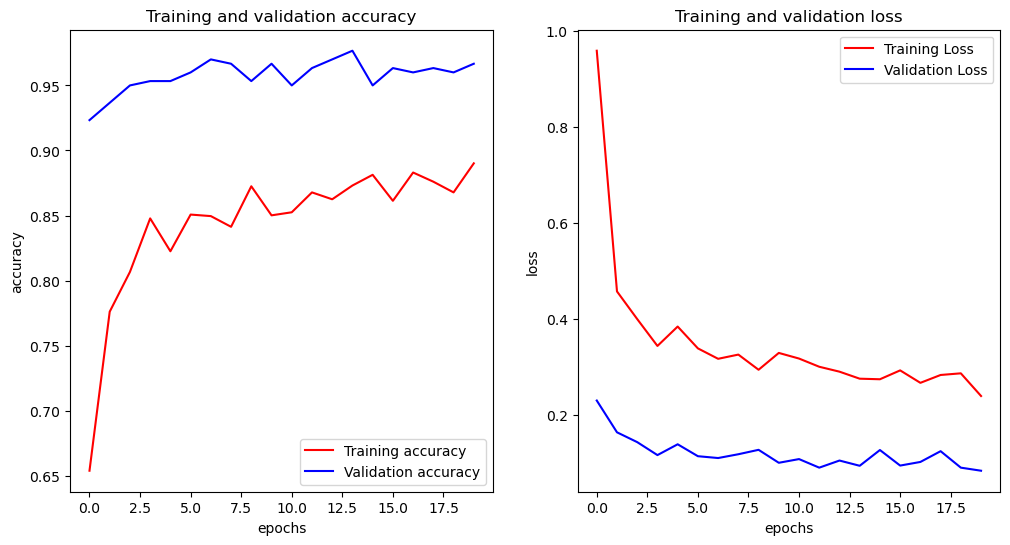

In [654]:
plot_loss_acc(TL_history)

### Model Prediction

In [678]:
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = TL_model_with_aug.predict(image, verbose=0)[0][0]
    
    with out:
        if prediction > 0.5:
            print(filename + " is a DOG")
        else:
            print(filename + " is a CAT")


def on_upload_change(change):
    # Get the newly uploaded file(s)
    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)

uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()